In [1]:
# set path
%cd /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/
#!/usr/bin/env python3
import uproot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns
import os
import vector
import time
# --- CONSTANTS ---
ELECTRON_MASS = 0.000511  # GeV/c^2
MUON_MASS = 0.1057        # GeV/c^2
HIGGS_MASS = 125.0        # GeV/c^2
Z_MASS = 91.1876          # GeV/c^2

def load_data(file_paths, tree_name, columns, max_events):
    """
    Loads data from multiple ROOT files into a dictionary of Akward arrays.
    """
    data = {}
    for name, path in file_paths.items():
        print(f"Loading data from {path}...")
        try:
            with uproot.open(path) as file:
                tree = file[tree_name]
                data[name] = tree.arrays(columns, entry_stop=max_events)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            data[name] = None
    return data

# Configuration
TESTING_MODE = False
MAX_EVENTS = 100000 if TESTING_MODE else None
OUTPUT_DIR = "figure/test"
os.makedirs(OUTPUT_DIR, exist_ok=True)


file_paths = {
    "HZ4Lep": "Bg1_hz.root",
    "ZWW4Lep": "Bg2_zww.root",
    "LFV_hm110": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass110_Seed110/HZ4l_HLFV_1M_HMass110_Seed110_IDEA.root",
    "LFV_hm115": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass115_Seed115/HZ4l_HLFV_1M_HMass115_Seed115_IDEA.root",
    "LFV_hm120": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass120_Seed120/HZ4l_HLFV_1M_HMass120_Seed120_IDEA.root",
    "LFV_hm125": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass125_Seed125/HZ4l_HLFV_1M_HMass125_Seed125_IDEA.root",
    "LFV_hm130": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass130_Seed130/HZ4l_HLFV_1M_HMass130_Seed130_IDEA.root",
    "LFV_hm135": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass135_Seed135/HZ4l_HLFV_1M_HMass135_Seed135_IDEA.root",
    "LFV_hm140": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass140_Seed140/HZ4l_HLFV_1M_HMass140_Seed140_IDEA.root",
    "LFV_hm145": "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass145_Seed145/HZ4l_HLFV_1M_HMass145_Seed145_IDEA.root"
}

columns = [
    "MissingET_size", "MissingET.Eta", "MissingET.Phi", "MissingET.MET",
    "Jet_size", "Jet.Phi", "Jet.Eta", "Jet.PT", "Jet.Mass",
    "Electron_size", "Electron.Eta", "Electron.Phi", "Electron.PT","Electron.Charge",
    "Muon_size", "Muon.Eta", "Muon.Phi", "Muon.PT","Muon.Charge"
]

raw_data = load_data(file_paths, "Delphes", columns, MAX_EVENTS)


/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis
Loading data from Bg1_hz.root...
Loading data from Bg2_zww.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass110_Seed110/HZ4l_HLFV_1M_HMass110_Seed110_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass115_Seed115/HZ4l_HLFV_1M_HMass115_Seed115_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass120_Seed120/HZ4l_HLFV_1M_HMass120_Seed120_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass125_Seed125/HZ4l_HLFV_1M_HMass125_Seed125_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass130_Seed130/HZ4

In [2]:
def plot_three_data(data_arrays, settings, output_dir):
    """
    Generates and saves a histogram for three datasets.
    """
    if len(data_arrays) != 3:
        raise ValueError("This function requires exactly three data arrays.")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    signalType = list(data_arrays.keys())[::-1]
    
    # Handle both flattened and already flattened arrays
    a=data_arrays[signalType[2]]
    b=data_arrays[signalType[1]]
    c=data_arrays[signalType[0]]
    cutLevel=settings["prefix"]
    if cutLevel != "0unCut":
        a=a[a[cutLevel]][settings['name']]
        b=b[b[cutLevel]][settings['name']]
        c=c[c[cutLevel]][settings['name']]
    else:
        a=a[settings['name']]
        b=b[settings['name']]
        c=c[settings['name']]
    try:
        n_arr = [ak.flatten(a[~ak.is_none(a)]), 
                 ak.flatten(b[~ak.is_none(b)]), 
                 ak.flatten(c[~ak.is_none(c)])]
    except:
        n_arr = [a, b, c]
    print("Begin set bin")
    if settings['binrange'] == '':
        minlist = [ak.min(n) for n in n_arr]
        maxlist = [ak.max(n) for n in n_arr]
        settings['binrange']=(ak.min(minlist),ak.max(maxlist))
    sns.set_theme(style="ticks")
    sns.histplot(n_arr, bins=settings["bins"], binrange=settings["binrange"], ax=ax, fill=False,
                 element=settings["element"], alpha=settings["alpha"], palette=settings['colors'][::-1],
                 stat=settings["stat"], common_norm=False, multiple=settings["multiple"])
    
    ax.set_title(f"{settings['name']} - {settings['prefix']}")
    ax.set_xlabel(settings['xlabel'])
    ax.set_ylabel("Density")
    ax.legend(labels=settings['labels'])
    
    if settings['log_scale']:
        ax.set_yscale("log")

    png_name = f"{settings['prefix']}_{settings['name']}{settings['suffix']}.png"
    plt.savefig(f"{output_dir}/{png_name}")
    print(f"-> {png_name} has been plotted!")
    plt.close()


def plot_data(data_arrays, prefix, output_dir, additional_plot=False):
    """
    Orchestrates the plotting of various variables for the datasets.
    """
    plot_configs = {
        'Electron.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Jet.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Jet.Mass': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': True},
        'Muon.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Electron.Eta': {'bins': 200, 'binrange': (-10, 10), 'xlabel': "", 'log_scale': False},
        'Muon.Eta': {'bins': 200, 'binrange': (-10, 10), 'xlabel': "", 'log_scale': False},
        'Electron.Phi': {'bins': 140, 'binrange': (-2 * np.pi, 2 * np.pi), 'xlabel': "", 'log_scale': False},
        'Muon.Phi': {'bins': 140, 'binrange': (-2 * np.pi, 2 * np.pi), 'xlabel': "", 'log_scale': False},
        'MissingET.MET': {'bins': 130, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': True}
    }

    base_settings = {
        'prefix': prefix, 'element': "step", 'alpha': 0.4,
        'colors': ["#FF9966", "#6698ca", "#66cc99"],
        'labels': ["HZ4LepLFV", "ZWW4Lep", "HZ4Lep"],
        'multiple': "layer", 'stat': "density"
    }

    for name, config in plot_configs.items():
        settings = {**base_settings, **config, 'name': name}
        plot_three_data(data_arrays, settings, output_dir)

def first_cut_4l(array, name):
    """
    Filters events with exactly 4 leptons.
    """
    mask = (array["Electron_size"] + array["Muon_size"] == 4)
    # print(f"    {name}: {np.sum(mask)}/{len(mask)} : {np.sum(mask) / len(mask) * 100:.2f}%")
    return mask

def second_cut_lepton_flavor(array, name, pmask):
    """
    Filters events with an odd number of electrons and muons.
    """
    mask = (array["Electron_size"] % 2 != 0) & (array["Muon_size"] % 2 != 0) & pmask
    # print(f"    {name}: {np.sum(mask)}/{len(mask)} : {np.sum(mask) / len(mask) * 100:.2f}%")
    return mask


In [3]:

print("\nChecking uncut events...")
for name, arr in raw_data.items():
    all_events=MAX_EVENTS if MAX_EVENTS is not None else len(arr)
    # Use a list of dictionaries for easier field addition later
    additional_fields = {}
    print(f"      {name}: {len(arr)} events")
    print(f"-> Applying cut on {name}...")
    # First cut: exactly 4 leptons
    additional_fields["1stCut"] = (arr["Electron_size"] + arr["Muon_size"] == 4)
    # Second cut: odd number leptons
    additional_fields["2ndCut"] = (arr["Electron_size"] % 2 != 0) & (arr["Muon_size"] % 2 != 0) & additional_fields["1stCut"]
    # Third cut: non charge-violation
    additional_fields["3rdCut"] = (ak.prod(arr["Electron.Charge"], axis=1) * ak.prod(arr["Muon.Charge"],axis=1) == 1
                                   )&(ak.sum(arr["Electron.Charge"],axis=1)+ak.sum(arr["Muon.Charge"],axis=1) == 0
                                      )&(ak.all(arr["Electron.Charge"],axis=1)&ak.all(arr["Muon.Charge"],axis=1)
                                      )&(additional_fields["2ndCut"] == 1)
    # Pre-Fourth cut:
    
        # test 
    # testarray=arr[additional_fields["3rdCut"]][:100]
    testarray=ak.mask(arr,additional_fields["3rdCut"])
    lmass={"Electron":ELECTRON_MASS,"Muon":MUON_MASS}
    bothZmasses={}
    bothReHiggsMass={}
    bothHiggsMass={}
    bothEditReDeMETHiggs={}
    leptons={"Electron","Muon"}
    # Useing Z mas as criterion to select lepton type
    for lepton in leptons:
        muonpaircombinations=ak.combinations(testarray[lepton+".Charge"],2,axis=1)
        muonpaircombinations_mask=muonpaircombinations['1']!=muonpaircombinations['0']
        muonpaircombinationsarg=ak.argcombinations(testarray[lepton+".Charge"],2,axis=1)
        Newmuonpairarg=ak.mask(muonpaircombinationsarg,muonpaircombinations_mask)
        FirstMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["0"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["0"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["0"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        SecondMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["1"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["1"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["1"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        MuonPair=FirstMuon+SecondMuon
        Zcandi=abs(MuonPair.mass-Z_MASS)
        BestZIndex=ak.argmin(Zcandi,axis=1,keepdims=True)
        BestZMass=ak.firsts(MuonPair.mass[BestZIndex])
        bothZmasses[lepton]=BestZMass
        RecoiledHiggsMass=(vector.obj(px=0,py=0,pz=0,energy=240)-MuonPair[BestZIndex]).mass
        bothReHiggsMass[lepton]=RecoiledHiggsMass

        selectLFV_mask=3-muonpaircombinationsarg[BestZIndex]['0']-muonpaircombinationsarg[BestZIndex]['1']
        FirstLFV=vector.zip({
            "pt": ak.firsts(testarray[lepton+".PT"][selectLFV_mask]),
            "eta": ak.firsts(testarray[lepton+".Eta"][selectLFV_mask]),
            "phi": ak.firsts(testarray[lepton+".Phi"][selectLFV_mask]),
            "mass": [lmass[lepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        anotherlepton=({"Electron","Muon"}-{lepton}).pop()
        secondLFV=vector.zip({
            "pt": ak.firsts(testarray[anotherlepton+".PT"]),
            "eta": ak.firsts(testarray[anotherlepton+".Eta"]),
            "phi": ak.firsts(testarray[anotherlepton+".Phi"]),
            "mass": [lmass[anotherlepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        HiggsM=(FirstLFV+secondLFV).mass
        bothHiggsMass[lepton]=HiggsM

    # Using Higgs mass as criterion to select lepton type
    HiggsPairCandidates=ak.cartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidates_mask=(HiggsPairCandidates['0']!=HiggsPairCandidates['1'])
    HiggsPairCandidatesarg=ak.argcartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidatesarg=ak.mask(HiggsPairCandidatesarg,HiggsPairCandidates_mask)
    FirstHiggsInPair=vector.zip({
        "pt": testarray["Electron.PT"][HiggsPairCandidatesarg["0"]],
        "eta": testarray["Electron.Eta"][HiggsPairCandidatesarg["0"]], 
        "phi": testarray["Electron.Phi"][HiggsPairCandidatesarg["0"]],
        "mass": [ELECTRON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    SecondHiggsInPair=vector.zip({
        "pt": testarray["Muon.PT"][HiggsPairCandidatesarg["1"]],
        "eta": testarray["Muon.Eta"][HiggsPairCandidatesarg["1"]], 
        "phi": testarray["Muon.Phi"][HiggsPairCandidatesarg["1"]],
        "mass": [MUON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    HiggsPair=FirstHiggsInPair+SecondHiggsInPair
    HiggsPairMass=HiggsPair.mass
    HiggsPairDeltaMass=abs(HiggsPairMass-HIGGS_MASS)
    BestHiggsPairIndex=ak.argmin(HiggsPairDeltaMass,axis=1,keepdims=True)
    BestHiggsPairMass=ak.firsts(HiggsPairMass[BestHiggsPairIndex])
    ZRecoiledMass=(vector.obj(px=0,py=0,pz=0,energy=240)-HiggsPair[BestHiggsPairIndex]).mass
    # Selecting lepton type for Z reconstruction based on Higgs mass
    PTlTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.PT"],arr["Electron.PT"])
    EataLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Eta"],arr["Electron.Eta"])
    PhiLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Phi"],arr["Electron.Phi"])
    LTypeCandidateMass=ak.where(arr["Electron_size"]==1,MUON_MASS,ELECTRON_MASS)
    LTypeCandidate=vector.zip({
        "pt": PTlTypeCandidate,
        "eta": EataLTypeCandidate, 
        "phi": PhiLTypeCandidate,
        "mass": LTypeCandidateMass
    })
    num=len(BestHiggsPairIndex)
    NotNone_mask=~ak.is_none(BestHiggsPairIndex)
    row=np.arange(num)
    Zpair_mask=np.full((num,3),True)
    Zpair_mask[row[NotNone_mask],ak.firsts(BestHiggsPairIndex[NotNone_mask])]=False
    Zpair_mask=ak.mask(Zpair_mask,NotNone_mask)
    RecoZpair=ak.combinations(LTypeCandidate[Zpair_mask],2,axis=1)
    Zpair=RecoZpair['0']+RecoZpair['1']
    ZpairMass=Zpair.mass
    # Identifying lepton type based on Z mass
    ZfirstLFlavor=ak.where(arr['Electron_size']==3,["EE"],["MuMu"])


    additional_fields["Z_selectionMass"]=ak.where(~ak.is_none(bothZmasses["Electron"]),bothZmasses["Electron"],bothZmasses["Muon"])
    additional_fields["Higgs_recoiledMass"]=ak.firsts(ak.where(~ak.is_none(bothZmasses["Electron"]),bothReHiggsMass["Electron"],bothReHiggsMass["Muon"]))
    additional_fields["Higgs_reconstructedMass"]=ak.where(~ak.is_none(bothHiggsMass["Electron"]),bothHiggsMass["Electron"],bothHiggsMass["Muon"])
    additional_fields["Higgs_selectionMass"]=BestHiggsPairMass
    additional_fields["Z_recoiledMass"]=ak.firsts(ZRecoiledMass)
    additional_fields["Z_reconstructedMass"]=ak.firsts(ZpairMass)
    # Add all new fields to the array at once
    for field_name, field_values in additional_fields.items():
        raw_data[name] = ak.with_field(raw_data[name], field_values, field_name)
print("----------------------------***-------------------------------")



Checking uncut events...
      HZ4Lep: 1000000 events
-> Applying cut on HZ4Lep...
      ZWW4Lep: 1000000 events
-> Applying cut on ZWW4Lep...
      LFV_hm110: 1000000 events
-> Applying cut on LFV_hm110...
      LFV_hm115: 1000000 events
-> Applying cut on LFV_hm115...
      LFV_hm120: 1000000 events
-> Applying cut on LFV_hm120...
      LFV_hm125: 1000000 events
-> Applying cut on LFV_hm125...
      LFV_hm130: 1000000 events
-> Applying cut on LFV_hm130...
      LFV_hm135: 1000000 events
-> Applying cut on LFV_hm135...
      LFV_hm140: 1000000 events
-> Applying cut on LFV_hm140...
      LFV_hm145: 1000000 events
-> Applying cut on LFV_hm145...
----------------------------***-------------------------------


In [4]:

# plot_configs = {
#     'Z_selectionMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Higgs_recoiledMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Higgs_reconstructedMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Higgs_selectionMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Z_recoiledMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Z_reconstructedMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
#     'Higgs_recoiledMass_1': {'bins': 50, 'binrange': (110,150), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom'},
#     'Higgs_reconstructedMass_1': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_1bin'},
#     'Higgs_reconstructedMass_2': {'bins': 100, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_detailedbin'},
#     'Higgs_reconstructedMass_3': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_1bincount','stat':"count"},
#     'Higgs_selectionMass_1': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom'}
# }

# base_settings = {
#     'prefix': '3rdCut', 'element': "step", 'alpha': 1,
#     'colors': ["#FF9966", "#6698ca", "#66cc99"],
#     'labels': ["HZ4LepLFV", "ZWW4Lep", "HZ4Lep"],
#     'multiple': "layer", 'stat': "density"
# }
# for name, config in plot_configs.items():
#     if plot_configs[name].get('suffix') != '':
#         name=name[:-2]
#     settings = {**base_settings,**config, 'name': name}
#     plot_three_data(raw_data, settings, 'Figure')


In [50]:
# Additional Selection
for data_key in raw_data.keys():
    added_field={}
    if data_key in ["HZ4Lep","ZWW4Lep"]:
        continue
    This_data=raw_data[data_key]
    This_HiggsMass=float(data_key[-3:])
    added_field['4thCut']=(abs(This_data["Higgs_reconstructedMass"] - This_HiggsMass) <= 8.5) & This_data["3rdCut"]
    added_field[f'4thCut_{data_key[4:]}_HZ4L']=(abs(raw_data["HZ4Lep"]["Z_reconstructedMass"] - This_HiggsMass) <= 8.5) & raw_data["HZ4Lep"]["3rdCut"]
    added_field[f'4thCut_{data_key[4:]}_ZWW4L']=(abs(raw_data["ZWW4Lep"]["Z_reconstructedMass"] - This_HiggsMass) <= 8.5) & raw_data["ZWW4Lep"]["3rdCut"]
    added_field['5thCut']= ak.all(This_data['Electron.PT'] > 10, axis=-1) & ak.all(This_data['Muon.PT'] > 10, axis=-1) & added_field['4thCut']
    added_field[f'5thCut_{data_key[4:]}_HZ4L']= ak.all(raw_data["HZ4Lep"]['Electron.PT'] > 10, axis=-1) & ak.all(raw_data["HZ4Lep"]['Muon.PT'] > 10, axis=-1) & added_field[f'4thCut_{data_key[4:]}_HZ4L']
    added_field[f'5thCut_{data_key[4:]}_ZWW4L']= ak.all(raw_data["ZWW4Lep"]['Electron.PT'] > 10, axis=-1) & ak.all(raw_data["ZWW4Lep"]['Muon.PT'] > 10, axis=-1) & added_field[f'4thCut_{data_key[4:]}_ZWW4L']
    raw_data[data_key]=ak.with_field(This_data,added_field["4thCut"],'4thCut')
    raw_data["HZ4Lep"]=ak.with_field(raw_data["HZ4Lep"],added_field[f'4thCut_{data_key[4:]}_HZ4L'],f'4thCut_{data_key[4:]}')
    raw_data["ZWW4Lep"]=ak.with_field(raw_data["ZWW4Lep"],added_field[f'4thCut_{data_key[4:]}_ZWW4L'],f'4thCut_{data_key[4:]}')
    raw_data[data_key]=ak.with_field(raw_data[data_key],added_field["5thCut"],'5thCut')
    raw_data["HZ4Lep"]=ak.with_field(raw_data["HZ4Lep"],added_field[f'5thCut_{data_key[4:]}_HZ4L'],f'5thCut_{data_key[4:]}')
    raw_data["ZWW4Lep"]=ak.with_field(raw_data["ZWW4Lep"],added_field[f'5thCut_{data_key[4:]}_ZWW4L'],f'5thCut_{data_key[4:]}')

In [6]:
# # Formatted Cut Report Table
# # Assuming 'raw_data' is a dictionary structured like this:
# # raw_data = {
# #     'Dataset_A': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
# #     'Dataset_B': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
# # }

# cut_list = ["1stCut", "2ndCut", "3rdCut"]
# data_names = list(raw_data.keys())

# # --- Define Column Widths for Formatting ---
# # Adjust these values as needed for your data names
# header_col_width = 15
# data_col_width = 25

# # --- Print Table Header ---
# # Start with an empty cell for the top-left corner
# header = f"{'Cut Name':<{header_col_width}}"
# # Add each dataset name as a column header
# for name in data_names:
#     header += f"{name:<{data_col_width}}"
# print(header)
# print("-" * len(header)) # Print a separator line

# # --- Print Data Rows ---
# for cut_name in cut_list:
#     # Start the row with the current cut name
#     row_str = f"{cut_name:<{header_col_width}}"
    
#     # Iterate through each dataset to get the corresponding data for the current cut
#     for name in data_names:
#         arr = raw_data[name]
#         # Get total events from the first cut (as in the original code)
#         total_events = len(arr["1stCut"])
        
#         # Calculate passed events for the current cut
#         mask = arr[cut_name]
#         passed_events = np.sum(mask)
        
#         # Avoid division by zero
#         if total_events > 0:
#             percentage = (passed_events / total_events) * 100
#             cell_content = f"{passed_events}/{total_events} ({percentage:.2f}%)"
#         else:
#             cell_content = "0/0 (N/A)"
            
#         # Add the formatted data cell to the row string
#         row_str += f"{cell_content:<{data_col_width}}"
        
#     print(row_str)

# print("\nAll done!")

In [52]:
# Formatted Cut Report Table
# Assuming 'raw_data' is a dictionary structured like this:
# raw_data = {
#     'Dataset_A': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
#     'Dataset_B': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
# }

cut_list = ["1stCut", "2ndCut", "3rdCut", "4thCut", "5thCut"]
data_names = list(raw_data.keys())


# --- Define Column Widths for Formatting ---
# Adjust these values as needed for your data names
header_col_width = 15
data_col_width = 25
data_collected={}
for anchor_name in data_names:
    if anchor_name in ["HZ4Lep","ZWW4Lep"]:
        continue
    data_collected[anchor_name]={}
     # --- Print Table Header ---
    print(f"\nCut Flow Report for {anchor_name}:")
    This_Set_name = ['HZ4Lep','ZWW4Lep',anchor_name]
    # --- Print Table Header ---
    # Start with an empty cell for the top-left corner
    header = f"{'Cut Name':<{header_col_width}}"
    # Add each dataset name as a column header
    for name in ['HZ4Lep','ZWW4Lep',anchor_name]:
        header += f"{name:<{data_col_width}}"
    print(header)
    print("-" * len(header)) # Print a separator line

    # --- Print Data Rows ---
    for cut_name in cut_list:
        # Start the row with the current cut name
        row_str = f"{cut_name:<{header_col_width}}"
        
        # Iterate through each dataset to get the corresponding data for the current cut
        for name in This_Set_name:
            arr = raw_data[name]
            # Get total events from the first cut (as in the original code)
            total_events = len(arr["1stCut"])
            
            # Calculate passed events for the current cut
            if cut_name in ["4thCut", "5thCut"]:
                if name == anchor_name:
                    mask = arr[cut_name]
                else:
                    mask = arr[f'{cut_name}_{anchor_name[4:]}']
            else:
                mask = arr[cut_name]
            passed_events = np.sum(mask)
            if cut_name in ["4thCut", "5thCut"]:
                data_collected[anchor_name][name]=(passed_events,total_events)
            
            # Avoid division by zero
            if total_events > 0:
                percentage = (passed_events / total_events) * 100
                cell_content = f"{passed_events}/{total_events} ({percentage:.2f}%)"
            else:
                cell_content = "0/0 (N/A)"
                
            # Add the formatted data cell to the row string
            row_str += f"{cell_content:<{data_col_width}}"
            
        print(row_str)
        print("")

print("\nAll done!")


Cut Flow Report for LFV_hm110:
Cut Name       HZ4Lep                   ZWW4Lep                  LFV_hm110                
------------------------------------------------------------------------------------------
1stCut         590512/1000000 (59.05%)  590606/1000000 (59.06%)  668065/1000000 (66.81%)  

2ndCut         294732/1000000 (29.47%)  294795/1000000 (29.48%)  668000/1000000 (66.80%)  

3rdCut         294689/1000000 (29.47%)  294758/1000000 (29.48%)  667965/1000000 (66.80%)  

4thCut         9244/1000000 (0.92%)     9203/1000000 (0.92%)     617264/1000000 (61.73%)  

5thCut         8179/1000000 (0.82%)     8201/1000000 (0.82%)     581699/1000000 (58.17%)  


Cut Flow Report for LFV_hm115:
Cut Name       HZ4Lep                   ZWW4Lep                  LFV_hm115                
------------------------------------------------------------------------------------------
1stCut         590512/1000000 (59.05%)  590606/1000000 (59.06%)  663230/1000000 (66.32%)  

2ndCut         29473

In [53]:
# Calculate Yeilds of each Signal and Background after all cuts
print("Yield Report after all cuts:")
Yield=data_collected.copy()
signal_yield=[]
zww4l_yield=[]
hz4l_yield=[]
for anchor_name, data in Yield.items():
    print(f"\nYield Report for {anchor_name}:")
    for dataset_name, (passed_events, total_events) in data.items():
        if total_events > 0:
            if dataset_name == anchor_name:
                yeild = passed_events / total_events # Assuming 1ab^-1 luminosity and 1M events
                signal_yield.append(yeild)
            elif dataset_name == "HZ4Lep":
                luminosity = total_events/2.797 # N=xsec * luminosity
                yeild =  passed_events/luminosity # scale to 1ab^-1 luminosity
                hz4l_yield.append(yeild)
            elif dataset_name == "ZWW4Lep":
                luminosity = total_events/2.691 # N=xsec * luminosity
                yeild =  passed_events/luminosity # scale to 1ab^-1 luminosity
                zww4l_yield.append(yeild)
            print(f"{dataset_name}: {yeild:.6f} events/ab^-1")
            data[dataset_name]=yeild
        else:
            print(f"{dataset_name}: 0/0 (N/A)")

Yield Report after all cuts:

Yield Report for LFV_hm110:
HZ4Lep: 0.022877 events/ab^-1
ZWW4Lep: 0.022069 events/ab^-1
LFV_hm110: 0.581699 events/ab^-1

Yield Report for LFV_hm115:
HZ4Lep: 0.013686 events/ab^-1
ZWW4Lep: 0.013194 events/ab^-1
LFV_hm115: 0.577631 events/ab^-1

Yield Report for LFV_hm120:
HZ4Lep: 0.007493 events/ab^-1
ZWW4Lep: 0.006959 events/ab^-1
LFV_hm120: 0.572387 events/ab^-1

Yield Report for LFV_hm125:
HZ4Lep: 0.003636 events/ab^-1
ZWW4Lep: 0.003528 events/ab^-1
LFV_hm125: 0.567325 events/ab^-1

Yield Report for LFV_hm130:
HZ4Lep: 0.001608 events/ab^-1
ZWW4Lep: 0.001453 events/ab^-1
LFV_hm130: 0.562024 events/ab^-1

Yield Report for LFV_hm135:
HZ4Lep: 0.000557 events/ab^-1
ZWW4Lep: 0.000490 events/ab^-1
LFV_hm135: 0.555555 events/ab^-1

Yield Report for LFV_hm140:
HZ4Lep: 0.000129 events/ab^-1
ZWW4Lep: 0.000143 events/ab^-1
LFV_hm140: 0.547780 events/ab^-1

Yield Report for LFV_hm145:
HZ4Lep: 0.000025 events/ab^-1
ZWW4Lep: 0.000016 events/ab^-1
LFV_hm145: 0.543625 

In [54]:
signal_yield

[0.581699, 0.577631, 0.572387, 0.567325, 0.562024, 0.555555, 0.54778, 0.543625]

In [55]:
hz4l_yield

[0.022876663000000002,
 0.013685721000000001,
 0.007493163000000001,
 0.0036361000000000006,
 0.0016082750000000002,
 0.000556603,
 0.000128662,
 2.5173000000000004e-05]

In [56]:
zww4l_yield

[0.022068890999999997,
 0.013193973,
 0.006958926,
 0.003527901,
 0.00145314,
 0.0004897619999999999,
 0.00014262299999999998,
 1.6145999999999998e-05]

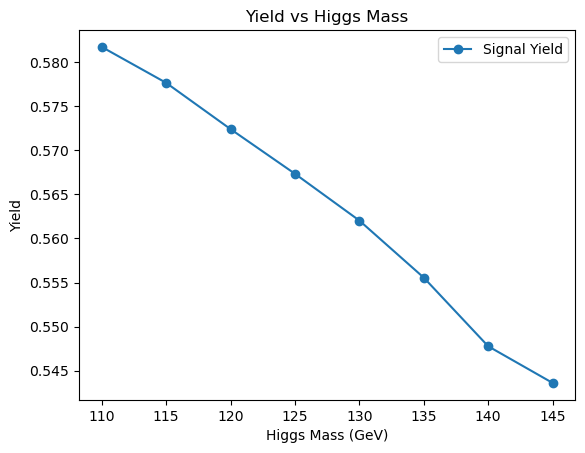

In [98]:
fig=plt.figure()
ax=fig.add_subplot(111)
# plt.plot([110,115,120,125,130,135,140,145],hz4l_yield,label="HZ4L Yield",marker='o')
# plt.plot([110,115,120,125,130,135,140,145],zww4l_yield,label="ZWW4L Yield",marker='o')
plt.plot([110,115,120,125,130,135,140,145],signal_yield,label="Signal Yield",marker='o')
plt.xlabel("Higgs Mass (GeV)")
plt.ylabel("Yield")
# plt.yscale("log")
plt.title("Yield vs Higgs Mass")
plt.legend()
plt.show()

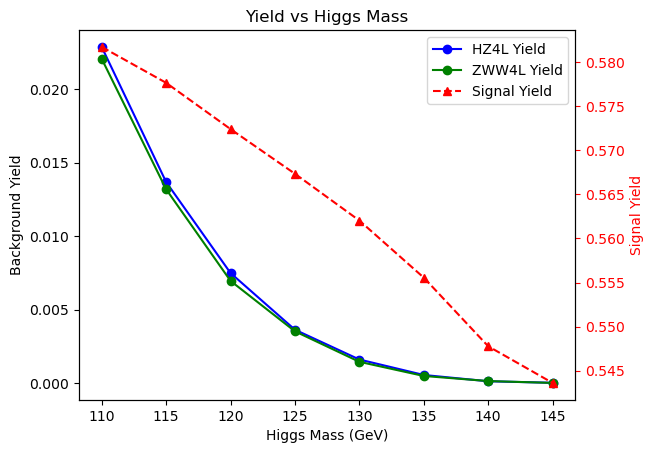

In [97]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# --- Plotting the "Other" (Backgrounds) on the Left Axis (ax1) ---
# We capture the plot objects (l1, l2) to use them in the legend later
l1, = ax1.plot([110,115,120,125,130,135,140,145], hz4l_yield, label="HZ4L Yield", marker='o', color='blue')
l2, = ax1.plot([110,115,120,125,130,135,140,145], zww4l_yield, label="ZWW4L Yield", marker='o', color='green')

ax1.set_xlabel("Higgs Mass (GeV)")
ax1.set_ylabel("Background Yield") # Label for the left side

# --- Create the Twin Axis ---
ax2 = ax1.twinx() 

# --- Plotting the "Signal" on the Right Axis (ax2) ---
l3, = ax2.plot([110,115,120,125,130,135,140,145], signal_yield, label="Signal Yield", marker='^', color='red', linestyle='--')

ax2.set_ylabel("Signal Yield")  # Label for the right side
# Optional: color the axis text to match the line so it's easier to read
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

# --- Combined Legend ---
# Since we have two axes, a standard plt.legend() might only show one.
# We combine the handles from both axes into one list.
lines = [l1, l2, l3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title("Yield vs Higgs Mass")
plt.show()

In [1]:
# editted signal yields base on genetor xsec
xsec_LFV_hm = ak.Array(
    [(110.0, 0.021482),
    (115.0, 0.019718),
    (120.0, 0.017863),
    (125.0, 0.015901),
    (130.0, 0.013802),
    (135.0, 0.011504),
    (140.0, 0.008877),
    (145.0, 0.0055491),
    (150.0, 0.00097792),
    (155.0, 0.00024781),
    (160.0, 0.00010705)])
xsec_only_values=xsec_LFV_hm['1']
xsec_multiplier= xsec_only_values / xsec_only_values[3]  # Normalize to the value at 125 GeV
editted_signal_yield = signal_yield * xsec_multiplier[:-3]
editted_signal_yield

NameError: name 'ak' is not defined

In [2]:
import awkward as ak
xsec_LFV_hm = ak.Array(
    [(110.0, 0.021482),
    (115.0, 0.019718),
    (120.0, 0.017863),
    (125.0, 0.015901),
    (130.0, 0.013802),
    (135.0, 0.011504),
    (140.0, 0.008877),
    (145.0, 0.0055491),
    (150.0, 0.00097792),
    (155.0, 0.00024781),
    (160.0, 0.00010705)])

In [14]:
a=ak.Array([1.35,
 1.24,
 1.12,
 1,
 0.868,
 0.723,
 0.558,
 0.349])
a

<Array [1.35, 1.24, 1.12, ... 0.558, 0.349] type='8 * float64'>

In [15]:
b=ak.Array([0.617264,
    0.611064,
    0.604286,
    0.597715,
    0.591248,
    0.583566,
    0.575209,
    0.569374])
[i for i in a*b]

[0.8333064000000001,
 0.7577193600000001,
 0.67680032,
 0.597715,
 0.513203264,
 0.421918218,
 0.32096662200000003,
 0.198711526]

In [58]:
xsec_multiplier

<Array [1.35, 1.24, 1.12, 1, ..., 0.0615, 0.0156, 0.00673] type='11 * float64'>

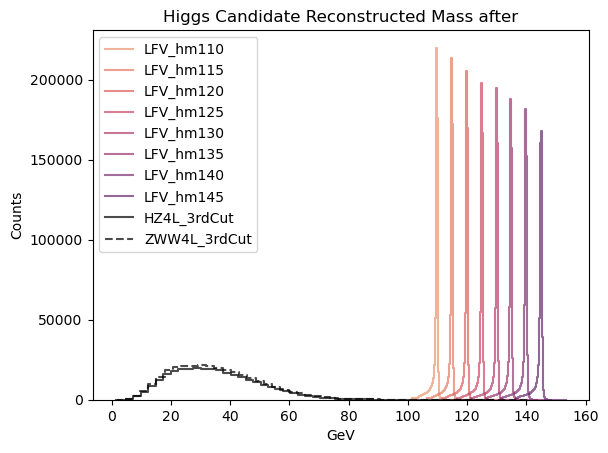

In [92]:
# Plottthing Higgs reconstructed mass after 4th cut for all LFV signals (layered)
fig=plt.figure()
ax=fig.add_subplot(111)
signalType=["LFV_hm110","LFV_hm115","LFV_hm120","LFV_hm125","LFV_hm130","LFV_hm135","LFV_hm140","LFV_hm145"]
colors=sns.color_palette("flare", len(signalType))
for i,signal in enumerate(signalType):
    a=raw_data[signal]
    cutLevel="5thCut"
    a=a[a[cutLevel]]["Higgs_reconstructedMass"]
    n_arr=(a[~ak.is_none(a)])
    sns.histplot(n_arr, bins=50,  ax=ax, fill=False,
                 element="step", alpha=0.7, color=colors[i],
                 stat="count", multiple="layer", label=signal)
bg1=raw_data['HZ4Lep']['Higgs_reconstructedMass'][raw_data['HZ4Lep']["3rdCut"]]
bg2=raw_data['ZWW4Lep']['Higgs_reconstructedMass'][raw_data['ZWW4Lep']["3rdCut"]]
sns.histplot(bg1[~ak.is_none(bg1)], bins=50,  ax=ax, fill=False,
             element="step", alpha=0.7, color='black',
             stat="count", multiple="layer", label="HZ4L_3rdCut")
sns.histplot(bg2[~ak.is_none(bg2)], bins=50,  ax=ax, fill=False,
             element="step", alpha=0.7, color='black', linestyle='dashed',
             stat="count", multiple="layer", label="ZWW4L_3rdCut")
ax.set_title(f"Higgs Candidate Reconstructed Mass after")
ax.set_xlabel("GeV")
ax.set_ylabel("Counts")
ax.legend(labels=signalType+["HZ4L_3rdCut","ZWW4L_3rdCut"])
plt.show()

In [82]:
upper_limit = np.array([4.627619057441712,
 4.592590632012857,
 4.637053599249206,
 4.713417939812745,
 4.767666784030083,
 4.759398948068958,
 4.898946768509928,
 4.970215716558242])

In [87]:
[i for i in range(110,150,5)]

[110, 115, 120, 125, 130, 135, 140, 145]

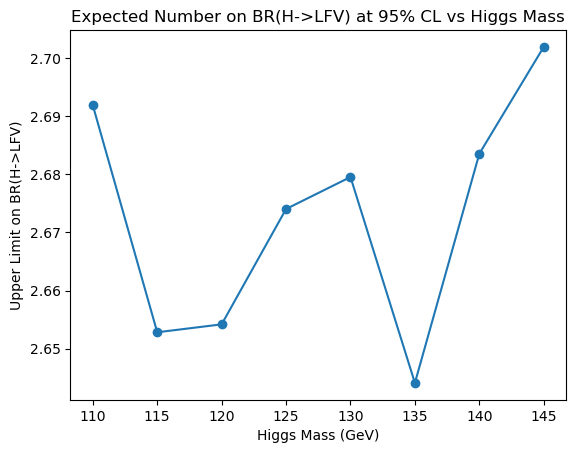

In [88]:
number=signal_yield*upper_limit
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot([i for i in range(110,150,5)], number, marker='o')
ax.set_title("Expected Number on BR(H->LFV) at 95% CL vs Higgs Mass")
ax.set_xlabel("Higgs Mass (GeV)")
ax.set_ylabel("Upper Limit on BR(H->LFV)")
plt.show()

In [84]:
signal_yield

[0.581699, 0.577631, 0.572387, 0.567325, 0.562024, 0.555555, 0.54778, 0.543625]

In [ ]:
# plt.figure(figsize=(10,5))
# plt.hist(_4cutZmass,alpha=0.5,bins=50,range=(80,100))
# plt.xlabel("Z mass (GeV)")
# # plt.yscale("log")
# plt.ylabel("Counts")
# plt.title("Histogram of Z mass after 4th cut")
# plt.show()
# plt.close()

In [ ]:
# plt.figure(figsize=(10,5))
# plt.hist2d(finalZmass,finalHmass,bins=50,cmin=1)
# plt.xlabel("Z mass (GeV)")
# plt.ylabel("Higgs reconstructed mass (GeV)")
# plt.title("2D Histogram of Z mass vs Higgs reconstructed mass after 4th cut")
# plt.show()